## Reaction Basics

### 0. Install the necessary Python libraries

In [2]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas rdkit mols2grid

### 1. Introduction
In this notebook we demonstrate a simple two-component library enumeration. We begin by sketching the reaction using the sketcher on the [Marvin JS Demo page](https://marvinjs-demo.chemaxon.com/latest/demo.html).  Once we've sketched the reaction, we will export the reaction as a **Reaction SMARTS** that can be processed by the RDKit. We will then look at how we can use that reaction SMARTS to enumerate a chemical library. A reaction SMARTS is similar to the SMARTS we saw in the previous notebook, with a couple of additions.  The reaction smarts consists of two parts separated by a reaction arrow, written as **">>"**. The part of the reaction SMARTS to the left of the reaction arrow represents the reactants and the part to the right represents the products.  The other difference from a typical SMARTS is the atom map numbers that follow the **":"** in the reaction SMARTS (shown in red in the figure below).  These specify the correspondence between reactant atoms and product atoms. Atom 1 in the reactants maps to atom 1 in the products, and so on.  By specifying reactions this way, we can transform a set of reactants into a reaction product. It's important to remember that reaction processing in the RDKit proceeds in two steps.
1. The reaction smarts for the reactants are mapped to the supplied reactants. This enables the RDKit reaction object to determine which reactant atoms will be transformed to product atoms. As such, it is important to specify the number of hydrogens attached to heteroatoms in the reactants.  We'll go into this more below.  Notice the hydrogen counts on the oxygen and the nitrogen in the reactants (highlighted in yellow).  We will also discuss this more in subsequent sections.
2. The atom mappings in the product are used to transform the reactants into products.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_000.png" alt="Drawing" style="width: 800px;"/>

### 2. Set Up the Reaction
In this section, we'll sketch a reaction and export it as a Reaction SMARTS that can be used by the RDKit. We begin by using the [Marvin JS Demo page](https://marvinjs-demo.chemaxon.com/latest/demo.html) to sketch an amide reaction. Note that it's not necessary to put a "+" between the reactants.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_001.png" alt="Drawing" style="width: 600px;"/>

Next we need to specify the hydrogen counts for any reactant heteroatoms with attached hydrogens.  This will improve the accuracy of the atom mapping.  For instance, the reaction above contains a carboxylic acid as a reactant.  We want our reaction to match carboxylic acids but not esters. We can do this by specifying that the acid oxygen has 1 attached hydrogen.  Similarly, if we want the primary amine in the reaction above to match primary amines and not secondary or tertiary amines, we can specify that the amine nitrogen must have 2 attached hydrogens. To specify the hydrogen counts do the following.
1. Right click on the atom of interest. Try this with the carboxylic acid oxygen.
2. Once you right click on an atom, you'll see a popup menu, select "Atom properties" from the menu.
3. After the menu selection you'll see a dialog box like the one shown in the figure below.
4. Click on the "Advanced" tab
5. Click the lock icon to the right of the "Total H (H)" field
6. Type "1" in the "Total H (H)" field.
7. Click "OK"

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_002.png" alt="Drawing" style="width: 300px;"/>

Repeat the procedure above and specify "Total H (H)" as 2 for the amine nitrogen.  After this you should see a notation on each of the two atoms showing the allowed number of attached hydrogens.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_003.png" alt="Drawing" style="width: 600px;"/>

Next we click on the automap icon to map the atoms in the reactants to atoms in the product.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_004.png" alt="Drawing" style="width: 600px;"/>

After mapping you'll see something like what's shown in the figure below. Note how the atom mapping establishes the correspondence between the reactant and product atom. Now each reactant atom is mapped to the corresponding product atoms. The hydroxyl oxygen, indicated by the arrow in the figure below, doesn't appear in the product. This atom has atom map number "3", but none of the product atoms have atom map number 3.  One important thing to remember about reactions in the RDKit is that **every mapped atom in the reactants must be mapped in the product**.  To use this reaction with the RDKit we need to remove atom map number 3.  Fortunately, this is easy to do.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_006.png" alt="Drawing" style="width: 600px;"/>

To make our reaction compatible with the RDKit, we need to "unmap" the hydroxyl oxygen.  To do this, follow these steps.
1. Right click on the hydroxyl oxygen and select "Atom properties" from the popup menu.
2. Click the "Advanced" tab in the dialog box.
3. Click the lock icon to the right of the "Map" field
4. Change the value "3" to "0".  This will remove the map from the atom.
5. Click "Ok"

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_007.png" alt="Drawing" style="width: 600px;"/>

At this point, the MarvinJS window should look like the figure below. Note that the hydroxyl oxygen no longer has an atom map number.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_008.png" alt="Drawing" style="width: 600px;"/>

We're almost there. All we have to do now is export the reaction as **SMARTS**.  To do this, click on the "Export" icon identified by the arrow in the figure below.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_009.png" alt="Drawing" style="width: 600px;"/>

### 3. Get the Reaction as Reaction SMARTS
Use the **"Format"** menu to set the format to **"SMARTS"** and copy the SMARTS to the clipboard. We can the paste the SMARTS into the code cell below.

<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/images/amiderxn_010.png" alt="Drawing" style="width: 500px;"/>

Allright, we've finished the preliminaries.  Let's write some code!  We begin by importing the necessary Python libraries.

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import mols2grid
from itertools import product

Assign a variable to the Reaction SMARTS we exported from MarvinJS.

In [4]:
rxn_smarts = "[#7H2:7]-[#6:9].[#8H]-[#6:1](-[#6:2])=[O:3]>>[#6:9]-[#7:7]-[#6:1](-[#6:2])=[O:3]"

Create an RDKit reaction molecule from the Reaction SMARTS.

In [8]:
rxn_smarts2="[#6:5]-[#7H2:6].[#6:2](-[#8H1])=[O:4]>>[#6:5]-[#7:6]-[#6:2](-[#6:1])=[O:4]"

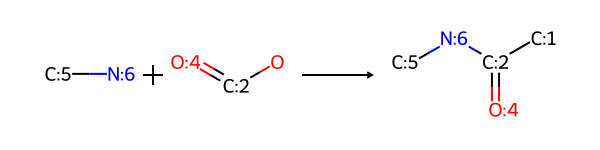

In [9]:
rxn_mol2 = AllChem.ReactionFromSmarts(rxn_smarts2)
rxn_mol2

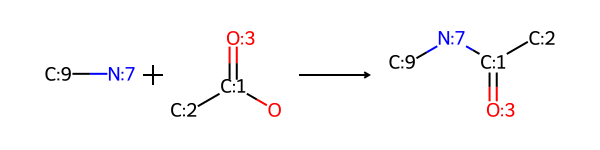

In [5]:
rxn_mol = AllChem.ReactionFromSmarts(rxn_smarts)
rxn_mol

### 4. Test the Reaction

Let's run a quick example to make sure our reaction works as expected.  We'll perform a simple reaction where we combine acetic acid with methylamine. **Note that the reactants must be in the same order specified in the reaction SMARTS.** If the reactants are not in the same order, you won't get a a reaction product.

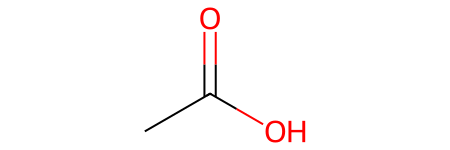

In [10]:
acid_mol = Chem.MolFromSmiles("CC(=O)O")
acid_mol

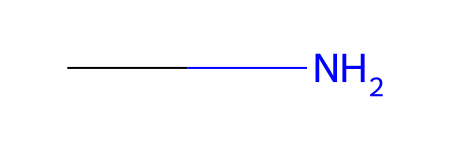

In [11]:
amine_mol = Chem.MolFromSmiles("CN")
amine_mol

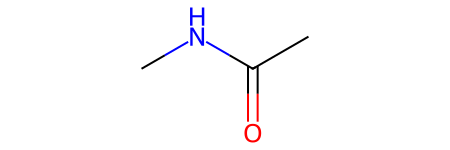

In [12]:
prods = rxn_mol.RunReactants([amine_mol, acid_mol])
prods[0][0]

### 5. Enumerate a SMALL library
Now we'll enumerate a library with 10 amines and 10 carboxylic acids.  We begin by reading the reagents from a file.

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/reaction/data/amide_reagents.csv")
df

,SMILES,Name,Type
0,N=C(N)NC[C@@H](N)C(=O)O,1576365,carboxylic_acid
1,CN(C)C[C@@H](N)C(=O)O,35024242,carboxylic_acid
2,Nc1nnn(CC(=O)O)n1,4294607,carboxylic_acid
3,COC(=O)[C@@H](O)CC(=O)O,14585673,carboxylic_acid
4,N=C(N)NC[C@H](N)C(=O)O,2384694,carboxylic_acid
5,N[C@H](CO)C(=O)O,895342,carboxylic_acid
6,NCC[C@H](N)C(=O)O,52986906,carboxylic_acid
7,C[C@@H](O)[C@H](N)C(=O)O,895103,carboxylic_acid
8,NC(=O)[C@H](N)CCC(=O)O,2560808,carboxylic_acid
9,NCC(=O)NCCC(=O)O,1637970,carboxylic_acid


Add a column to the dataframe with RDKit molecules.

In [14]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Split the acids and amines into separate dataframes.

In [15]:
acid_df = df.query("Type == 'carboxylic_acid'").copy()
amine_df = df.query("Type == 'primary_amine'").copy()

View the acids

In [16]:
mols2grid.display(acid_df,subset=["img","Name"])

MolGridWidget()

View the amines.

In [17]:
mols2grid.display(amine_df,subset=["img","Name"])

MolGridWidget()

Make lists of acids and amines to use for the enumeration.

In [18]:
acid_list = acid_df[['mol','Name']].values
amine_list = amine_df[['mol','Name']].values

Define a function to enumerate a library.

In [19]:
def enumerate_library(rxn_mol, reagent_lol):
    prod_list = []
    # itertools.product generates all combinations of reactants
    for reagents in product(*reagent_lol):
        mol_list = [x[0] for x in reagents]
        name_list = [str(x[1]) for x in reagents]
        name = "_".join(name_list)
        prod = rxn_mol.RunReactants(mol_list)
        if prod is not None and len(prod):
            product_mol = prod[0][0]
            Chem.SanitizeMol(product_mol)
            prod_list.append([Chem.MolToSmiles(product_mol), name])
    return prod_list

Enumerate the library

In [20]:
prod_list = enumerate_library(rxn_mol,[amine_list, acid_list])

Put the products into a dataframe

In [21]:
prod_df = pd.DataFrame(prod_list,columns=["SMILES","Name"])

View the products

In [22]:
mols2grid.display(prod_df,subset=["img","Name"])

MolGridWidget()

* Reaction SMARTS uses `>>` to separate reactants and products
* Atom map numbers (like `:[1]`, `:[2]`) map reactant atoms to product atoms
* Hydrogens on heteroatoms (like O and N) must be **explicitly specified** for accurate matching
* Set hydrogen counts in MarvinJS using Atom Properties → Advanced → “Total H (H)”
* For primary amines: nitrogen must have 2 Hs (`[#7H2]`), for carboxylic acids: hydroxyl O must have 1 H (`[#8H1]`)
* Atom mapping should be applied only to atoms that appear in both reactants and products
* If a mapped atom (e.g. hydroxyl oxygen) doesn't appear in product, remove its map (set Map = 0)
* After drawing and mapping the reaction in MarvinJS, export it as **SMARTS format**, not SMILES
* Use `ReactionFromSmarts()` in RDKit to create a reaction object from SMARTS
* Order of reactants in `RunReactants()` must match the order in the SMARTS (e.g. amine first, acid second)
* Use `MolFromSmiles()` to convert SMILES to molecule objects for reactions
* Use `.RunReactants()` to apply the reaction to molecule pairs
* Use `itertools.product()` to create all pairwise combinations of amines and acids
* Sanitize products with `Chem.SanitizeMol()` after generating them
* Store generated products and names in a list, then convert to a DataFrame
* `mols2grid.display()` can be used to visually display molecule tables in Colab

